## Setup

In [1]:
%run setup.ipynb
%matplotlib notebook

In [4]:
# setup callset - needed for variant annotations
callset_pass = phase1_ar31.callset_pass
pos_pass = allel.SortedIndex(callset_pass['2L/variants/POS'])
ann_pass = callset_pass['2L/variants/ANN'][:][['Annotation', 'HGVS_p']]

In [5]:
# setup haplotypes
callset_phased = phase1_ar31.callset_phased
genotypes_phased = allel.GenotypeDaskArray(callset_phased['2L/calldata/genotype'])
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
ref_phased = callset_phased['2L/variants/REF']
alt_phased = callset_phased['2L/variants/ALT']


In [6]:
pos_kdr_s = 2422651
pos_kdr_f = 2422652

In [7]:
# define region for EHH analysis
loc_region = pos_phased.locate_range(0, 4000000)
pos_phased_region = pos_phased[loc_region]
ref_phased_region = ref_phased[loc_region]
alt_phased_region = alt_phased[loc_region]
pos_phased_region

0,1,2,3,4,...,163958,163959,163960,163961,163962
44688,44691,44732,44736,44756,...,3997372,3997373,3997378,3997381,3997386


In [8]:
# locate the kdr variants within the haplotypes callset
idx_kdr_s = pos_phased_region.locate_key(pos_kdr_s)
idx_kdr_f = pos_phased_region.locate_key(pos_kdr_f)
idx_kdr_s, idx_kdr_f

(26000, 26001)

In [9]:
# locate the intersection - needed to tie in annotations
loc1, _ = pos_pass.locate_intersection(pos_phased_region)
np.count_nonzero(loc1)

163963

In [13]:
ann_phased_region = ann_pass[loc1]
ann_phased_region

array([(b'intergenic_region', b'.'), (b'intergenic_region', b'.'),
       (b'intergenic_region', b'.'), ...,
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.'),
       (b'downstream_gene_variant', b'.')], 
      dtype=[('Annotation', 'S34'), ('HGVS_p', 'S14')])

In [15]:
collections.Counter(ann_phased_region['Annotation'])

Counter({b'3_prime_UTR_variant': 2941,
         b'5_prime_UTR_premature_start_codon_': 306,
         b'5_prime_UTR_variant': 1677,
         b'downstream_gene_variant': 18539,
         b'initiator_codon_variant': 3,
         b'intergenic_region': 54849,
         b'intragenic_variant': 48,
         b'intron_variant': 32362,
         b'missense_variant': 5805,
         b'missense_variant&splice_region_var': 70,
         b'splice_acceptor_variant&intron_var': 24,
         b'splice_donor_variant&intron_varian': 27,
         b'splice_region_variant': 36,
         b'splice_region_variant&intron_varia': 649,
         b'splice_region_variant&stop_retaine': 5,
         b'splice_region_variant&synonymous_v': 87,
         b'start_lost': 9,
         b'stop_gained': 37,
         b'stop_lost&splice_region_variant': 4,
         b'stop_retained_variant': 5,
         b'synonymous_variant': 8636,
         b'upstream_gene_variant': 37844})

In [17]:
# exclude cross parents
haps_phased_region = genotypes_phased[loc_region].to_haplotypes()[:, :-16].compute()
haps_phased_region

<HaplotypeArray shape=(163963, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [18]:
loc_haps_kdr_s = haps_phased_region[idx_kdr_s] == 1
np.count_nonzero(loc_haps_kdr_s)

430

In [19]:
loc_haps_kdr_f = haps_phased_region[idx_kdr_f] == 1
np.count_nonzero(loc_haps_kdr_f)

775

In [20]:
loc_haps_kdr_l = ~loc_haps_kdr_s & ~loc_haps_kdr_f
np.count_nonzero(loc_haps_kdr_l)

325

In [21]:
ac_phased_region = haps_phased_region.count_alleles(max_allele=1)
ac_phased_region

<AlleleCountsArray shape=(163963, 2) dtype=int32>
1529    1
1528    2
1528    2
...
1527    3
1529    1
1527    3

In [83]:
region_vgsc = SeqFeature('2L', 2358158, 2431617, label='Vgsc')
region_vgsc

<SeqFeature 'Vgsc' 2L:2358158-2431617>

In [84]:
loc_vgsc = pos_phased_region.locate_range(region_vgsc.start, region_vgsc.end)
loc_vgsc

slice(24471, 26181, None)

In [91]:
haps_vgsc = haps_phased_region[loc_vgsc]
haps_vgsc

<HaplotypeArray shape=(1710, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [92]:
ac_vgsc = haps_vgsc.count_alleles(max_allele=1)
ac_vgsc

<AlleleCountsArray shape=(1710, 2) dtype=int32>
1529    1
1457   73
1528    2
...
1513   17
1525    5
1519   11

In [93]:
ann_vgsc = ann_phased_region[loc_vgsc]

In [96]:
loc_vgsc_missense = (ann_vgsc['Annotation'] == b'missense_variant') & (ac_vgsc[:, 1] > 7)
np.count_nonzero(loc_vgsc_missense)

16

In [97]:
haps_vgsc_missense = haps_vgsc[loc_vgsc_missense]
haps_vgsc_missense

<HaplotypeArray shape=(16, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 1 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [101]:
lbl_vgsc_missense = [l[2:] for l in ann_vgsc[loc_vgsc_missense]['HGVS_p'].astype('U')]
lbl_vgsc_missense

['Arg254Lys',
 'Asp466His',
 'Thr791Met',
 'Leu995Ser',
 'Leu995Phe',
 'Ala1125Val',
 'Ile1527Thr',
 'Glu1597Gly',
 'Ala1746Ser',
 'Val1853Ile',
 'Ile1868Thr',
 'Pro1874Ser',
 'Pro1874Leu',
 'Phe1920Ser',
 'Ala1934Val',
 'Ile1940Thr']

In [107]:
def plot_haplotypes(ax, h, mut_labels):
    mycol = ['w', 'k'] 
    cake = mpl.colors.ListedColormap(mycol, name='mymap', N=3)
    ax.pcolormesh(np.asarray(h[::-1]), cmap=cake, vmin=0, vmax=2)
    ax.set_yticks(np.arange(h.shape[0])+.5)
    ax.set_yticklabels(mut_labels[::-1], family='monospace')
    ax.hlines(np.arange(h.shape[0]+1), 0, h.shape[1], color='k', lw=.5)
    ax.set_xlim(0, h.shape[1])
    ax.set_ylim(0, h.shape[0])


<IPython.core.display.Javascript object>


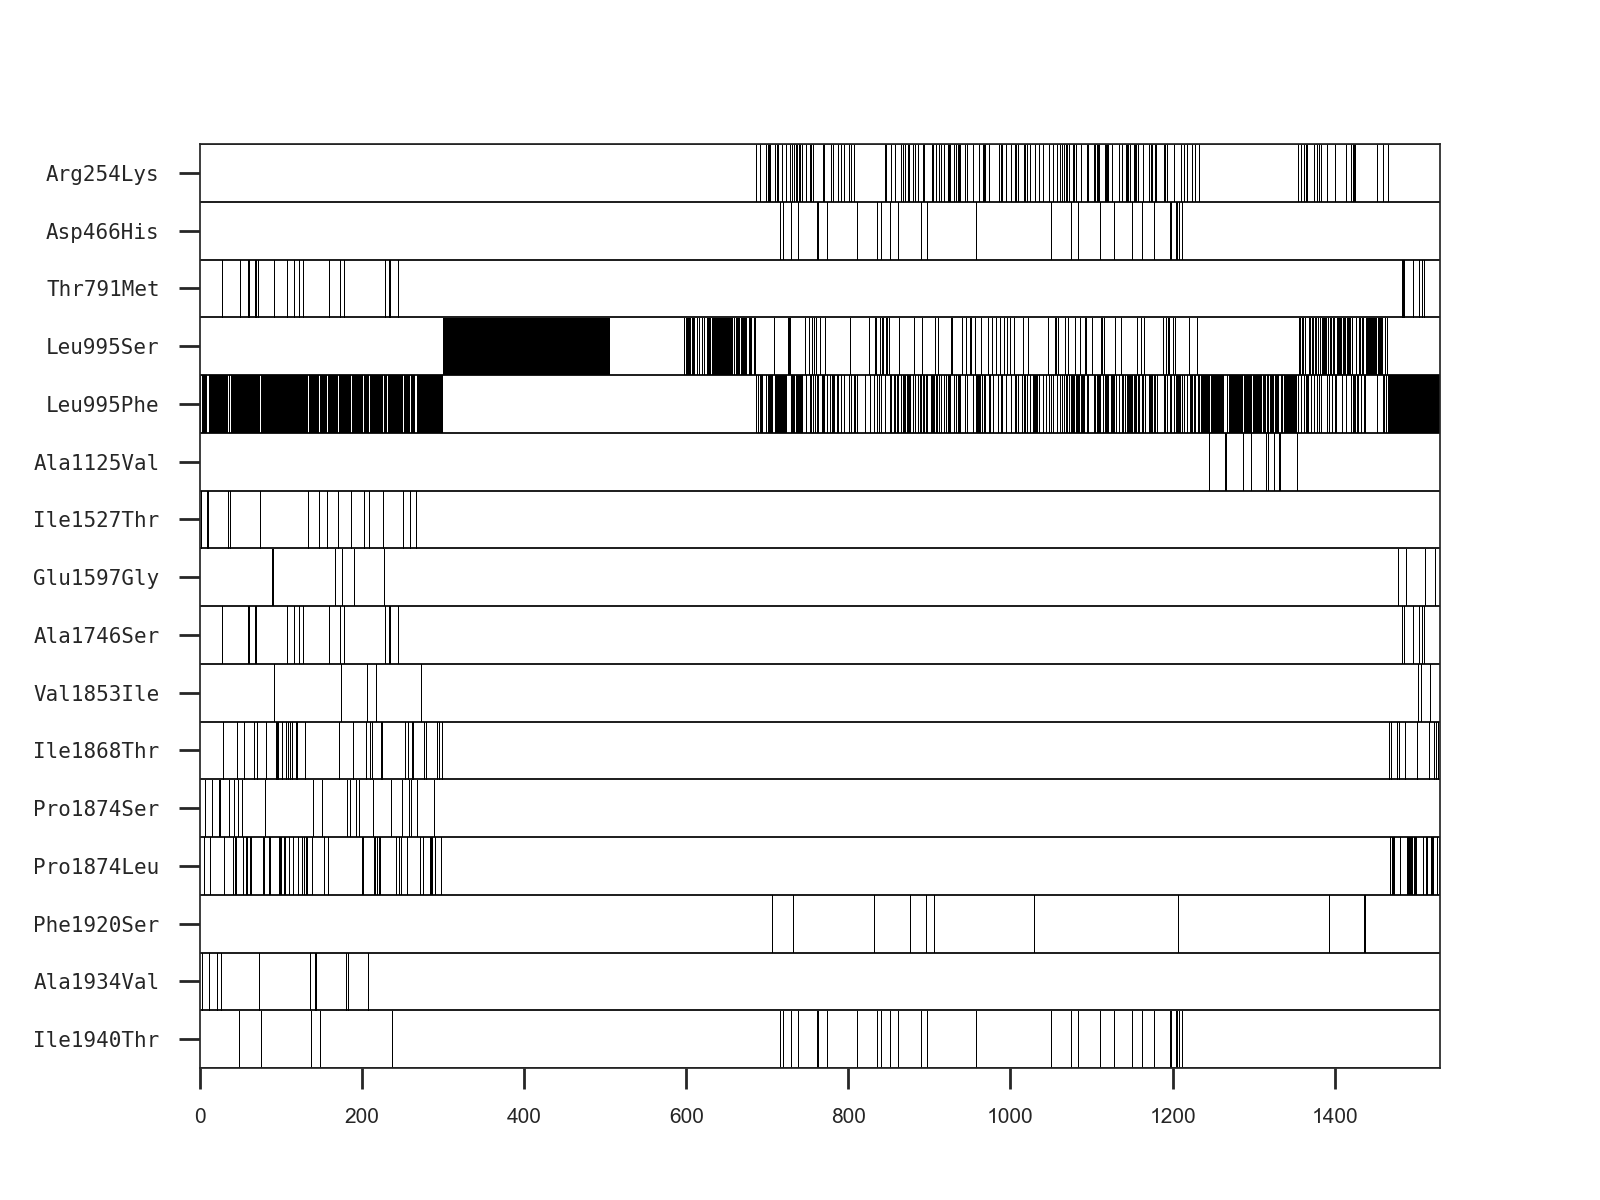

In [109]:
fig, ax = plt.subplots()
plot_haplotypes(ax, haps_vgsc_missense, lbl_vgsc_missense)

In [23]:
# define types of variants to include in EHH analysis - should be mostly neutral
loc_ehh_type = ((ann_phased_region['Annotation'] == b'intergenic_region') | 
                (ann_phased_region['Annotation'] == b'intron_variant') |
                (ann_phased_region['Annotation'] == b'downstream_gene_variant') |
                (ann_phased_region['Annotation'] == b'upstream_gene_variant') |
                (ann_phased_region['Annotation'] == b'synonymous_variant') |
                (ann_phased_region['Annotation'] == b'3_prime_UTR_variant') |
                (ann_phased_region['Annotation'] == b'5_prime_UTR_variant') 
               )
# patch back in kdr
loc_ehh_type[idx_kdr_s] = True
loc_ehh_type[idx_kdr_f] = True
np.count_nonzero(loc_ehh_type), loc_ehh_type.shape

(156850, (163963,))

In [25]:
# locate singletons - will exclude from EHH analysis
loc_ehh_sgl = ac_phased_region.min(axis=1) == 1
loc_ehh_nosgl = ac_phased_region.min(axis=1) > 1
np.count_nonzero(loc_ehh_sgl), np.count_nonzero(loc_ehh_nosgl), loc_ehh_nosgl.shape

(52221, 111611, (163963,))

In [27]:
# these are the variants to use for EHH
loc_ehh = loc_ehh_type & loc_ehh_nosgl
np.count_nonzero(loc_ehh), loc_ehh.shape

(107533, (163963,))

In [28]:
haps_ehh = haps_phased_region[loc_ehh]
haps_ehh

<HaplotypeArray shape=(107533, 1530) dtype=int8>
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
1 1 1 1 1 ... 1 1 1 1 1
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [29]:
pos_ehh = pos_phased_region[loc_ehh]
ref_ehh = ref_phased_region[loc_ehh]
alt_ehh = alt_phased_region[loc_ehh]
pos_ehh

0,1,2,3,4,...,107528,107529,107530,107531,107532
44691,44732,44756,44767,44872,...,3997366,3997367,3997373,3997378,3997386


In [31]:
idx_kdr_s_ehh = pos_ehh.locate_key(pos_kdr_s)
idx_kdr_f_ehh = pos_ehh.locate_key(pos_kdr_f)
idx_kdr_s_ehh, idx_kdr_f_ehh

(15754, 15755)

In [32]:
# read in haplotype metadata to get population
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes = df_haplotypes[df_haplotypes.population != 'colony']
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [33]:
loc_left_ehh = slice(0, idx_kdr_f_ehh+1)
loc_right_ehh = slice(idx_kdr_s_ehh, None)
loc_left_ehh, loc_right_ehh

(slice(0, 15756, None), slice(15754, None, None))

In [34]:
haps_left = haps_ehh[loc_left_ehh]
pos_left = pos_ehh[loc_left_ehh]
haps_right = haps_ehh[loc_right_ehh]
pos_right = pos_ehh[loc_right_ehh]

## Shared haplotype length

In [35]:
idx_right = haps_right.prefix_argsort()
haps_right_sorted = haps_right[:, idx_right]
haps_right_sorted

<HaplotypeArray shape=(91779, 1530) dtype=int8>
0 0 0 0 0 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [36]:
nspl_right = allel.opt.stats.neighbour_shared_prefix_lengths_int8(np.asarray(haps_right_sorted))
nspl_right

array([101, 132,  42, ...,  95,   4, 559], dtype=int32)

<IPython.core.display.Javascript object>


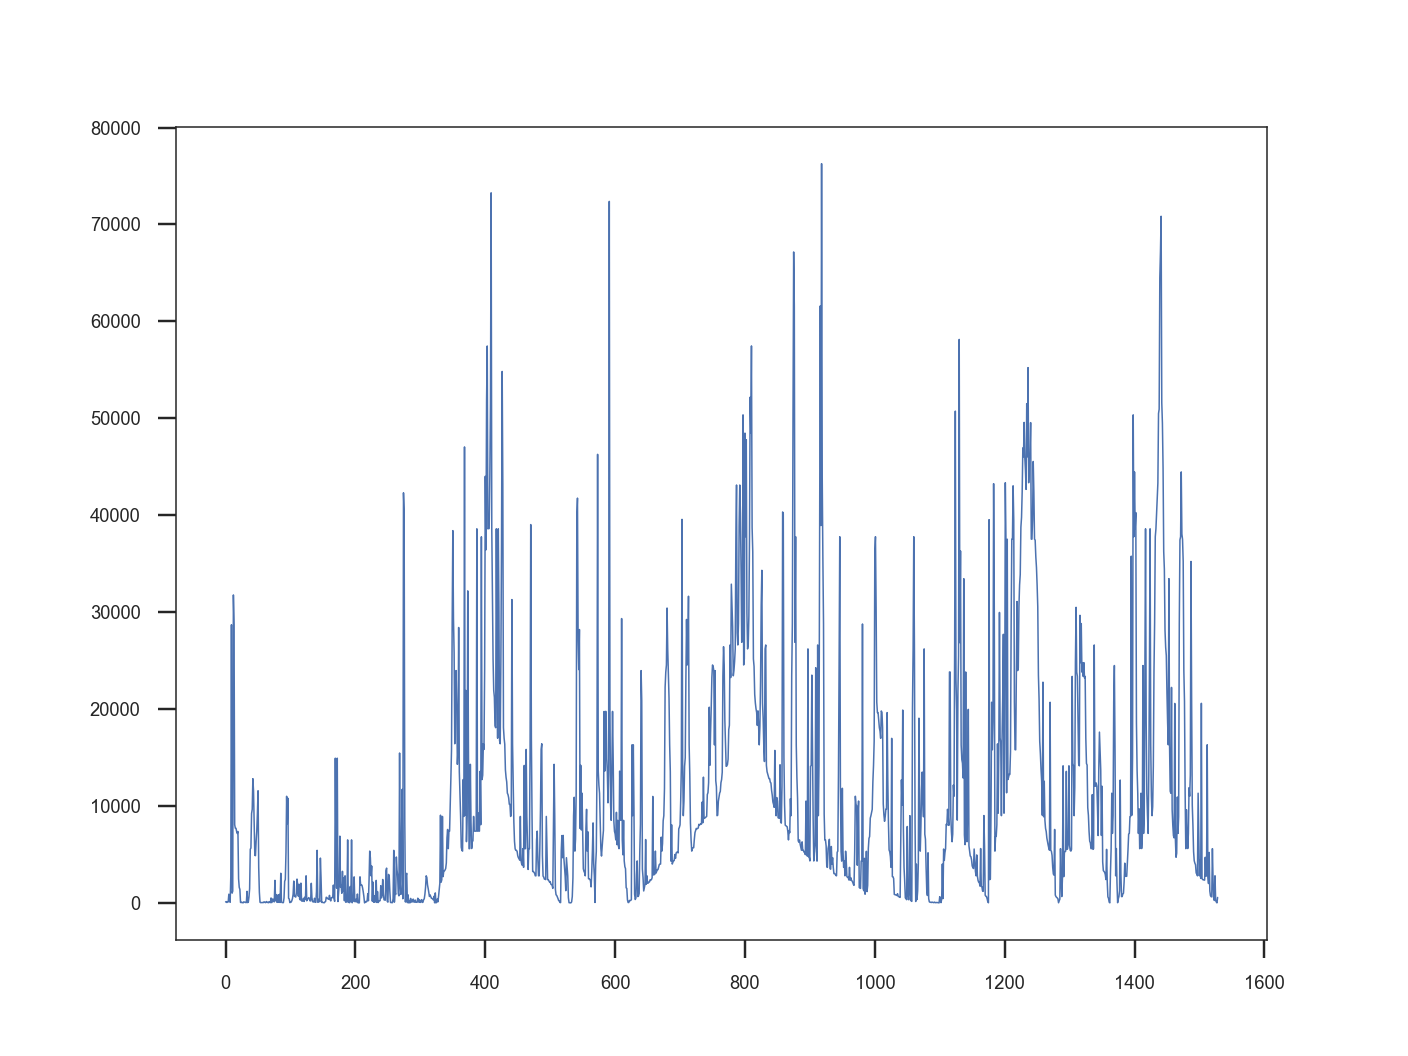

In [40]:
fig, ax = plt.subplots()
ax.plot(nspl_right);

In [38]:
nspd_right = np.asarray(pos_right)[nspl_right] - pos_right[0]
nspd_right

array([ 9151, 10212,  3583, ...,  8867,   259, 63712], dtype=int32)

<IPython.core.display.Javascript object>


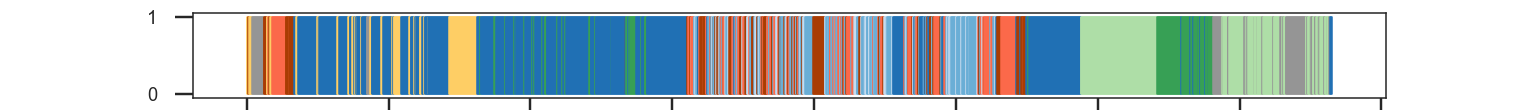

In [62]:
pops_right = df_haplotypes.population[idx_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]
fig, ax = plt.subplots(figsize=(7, .5))
ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors_right)

<IPython.core.display.Javascript object>


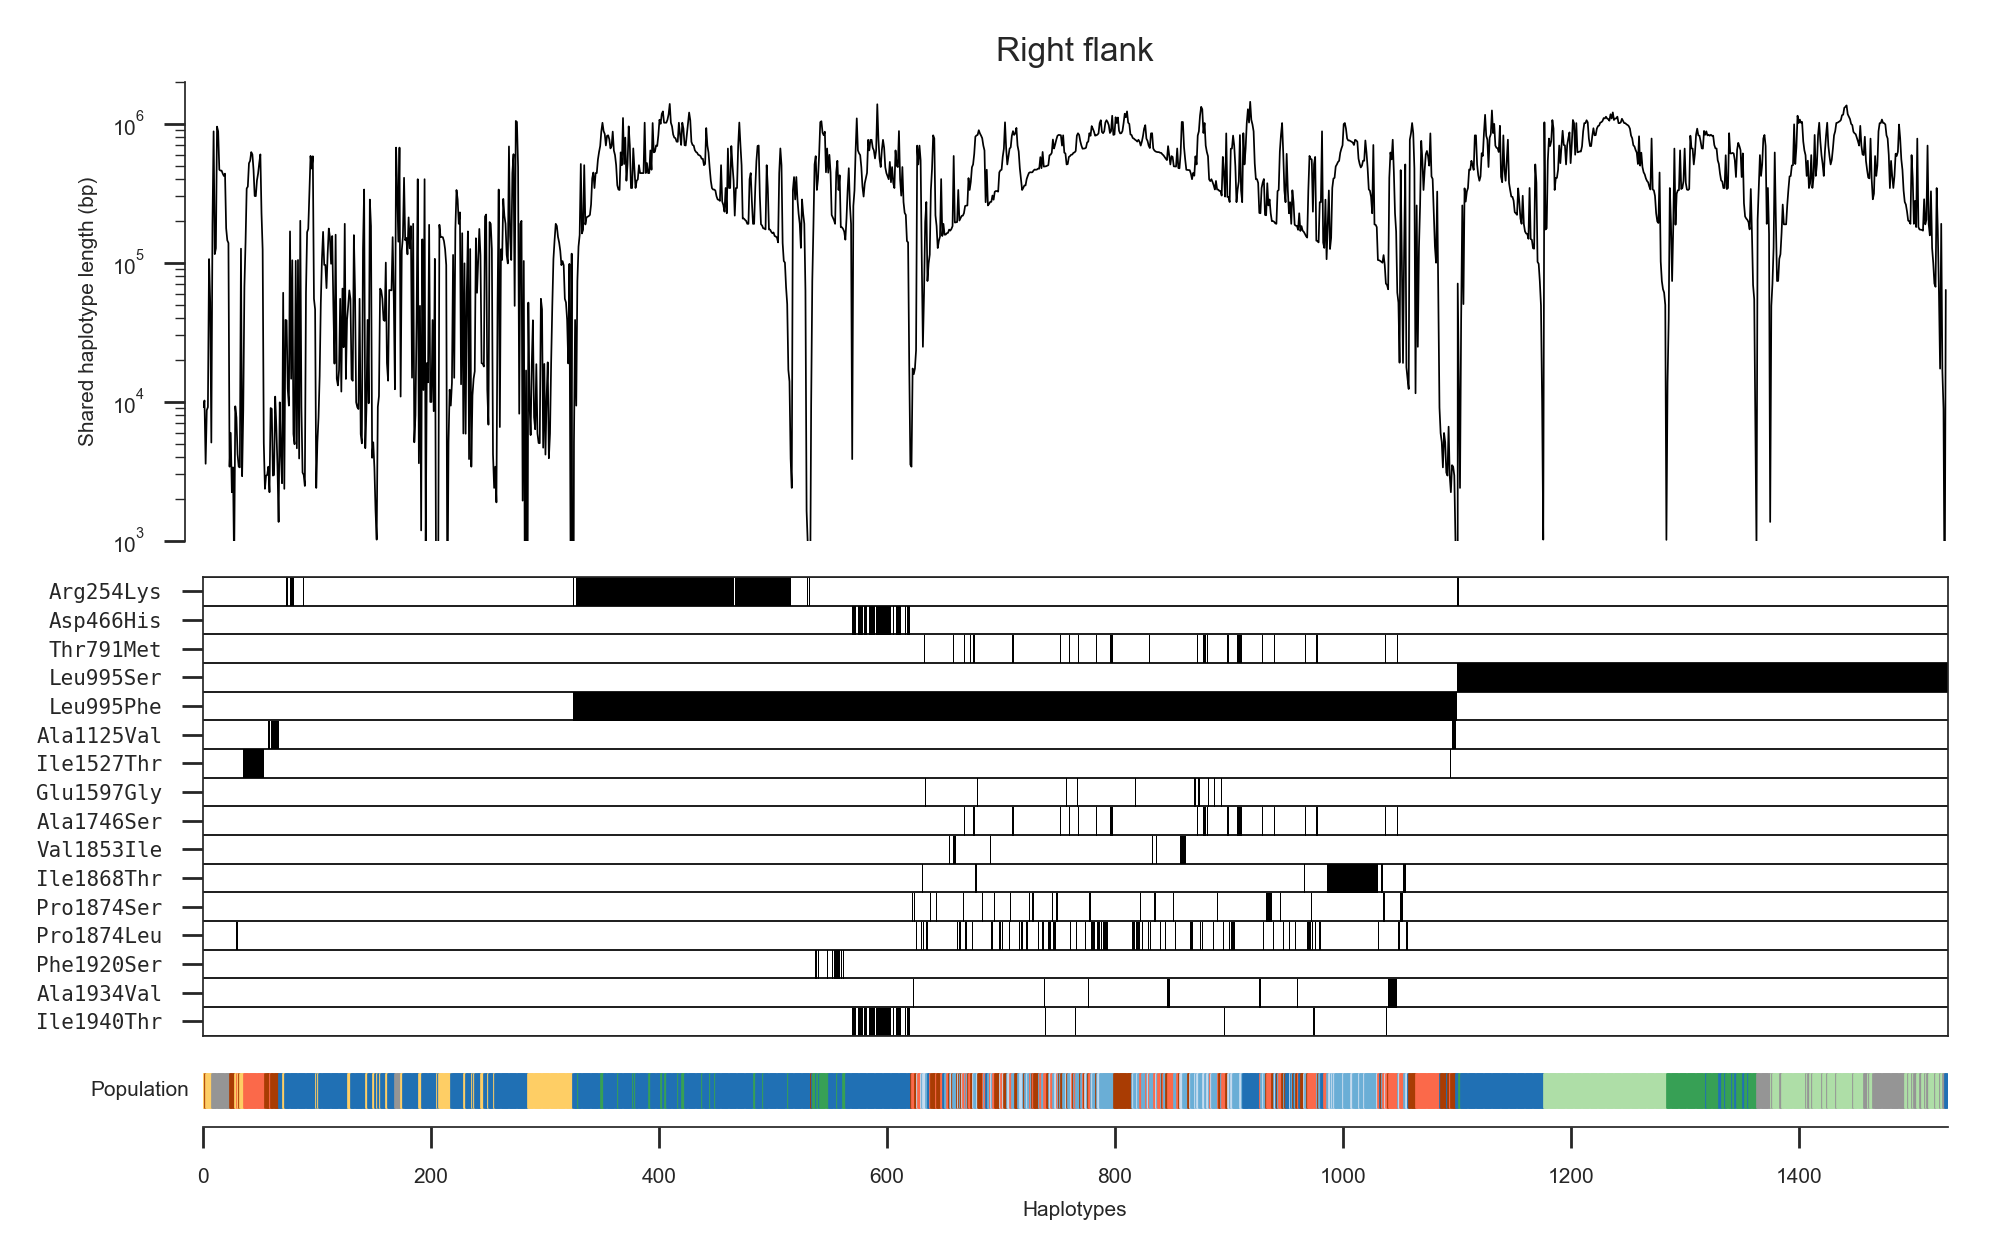

In [113]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=(6, 6, .5))

ax = fig.add_subplot(gs[0])
ax.set_title('Right flank')
sns.despine(ax=ax, offset=5, bottom=True)
# N.B., values are distances shared between haplotypes
x = np.arange(0, len(df_haplotypes))[:-1] + .5
y = nspd_right
ax.plot(x, y, color='k', lw=.5)
ax.set_yscale('log')
ax.set_ylim(1e3, 2e6)
ax.set_xlim(0, len(df_haplotypes))
ax.set_xticks([])
ax.set_ylabel('Shared haplotype length (bp)')

ax = fig.add_subplot(gs[1])
plot_haplotypes(ax, haps_vgsc_missense[:, idx_right], lbl_vgsc_missense)
ax.set_xlim(0, len(df_haplotypes))
ax.set_xticks([])

ax = fig.add_subplot(gs[2])
sns.despine(ax=ax, offset=5, left=True)
pops_right = df_haplotypes.population[idx_right]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_right]
ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors_right)
ax.set_xlim(0, len(df_haplotypes))
ax.set_yticks([])
ax.set_ylabel('Population', rotation=0, ha='right', va='center')

ax.set_xlabel('Haplotypes')

fig.tight_layout(h_pad=0);

In [114]:
idx_left = haps_left[::-1].prefix_argsort()
haps_left_sorted = haps_left[::-1, idx_left]
haps_left_sorted

<HaplotypeArray shape=(15756, 1530) dtype=int8>
0 0 0 0 0 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [115]:
nspl_left = allel.opt.stats.neighbour_shared_prefix_lengths_int8(np.asarray(haps_left_sorted))
nspl_left

array([14902, 10154,  8215, ...,    45,    11,     7], dtype=int32)

<IPython.core.display.Javascript object>


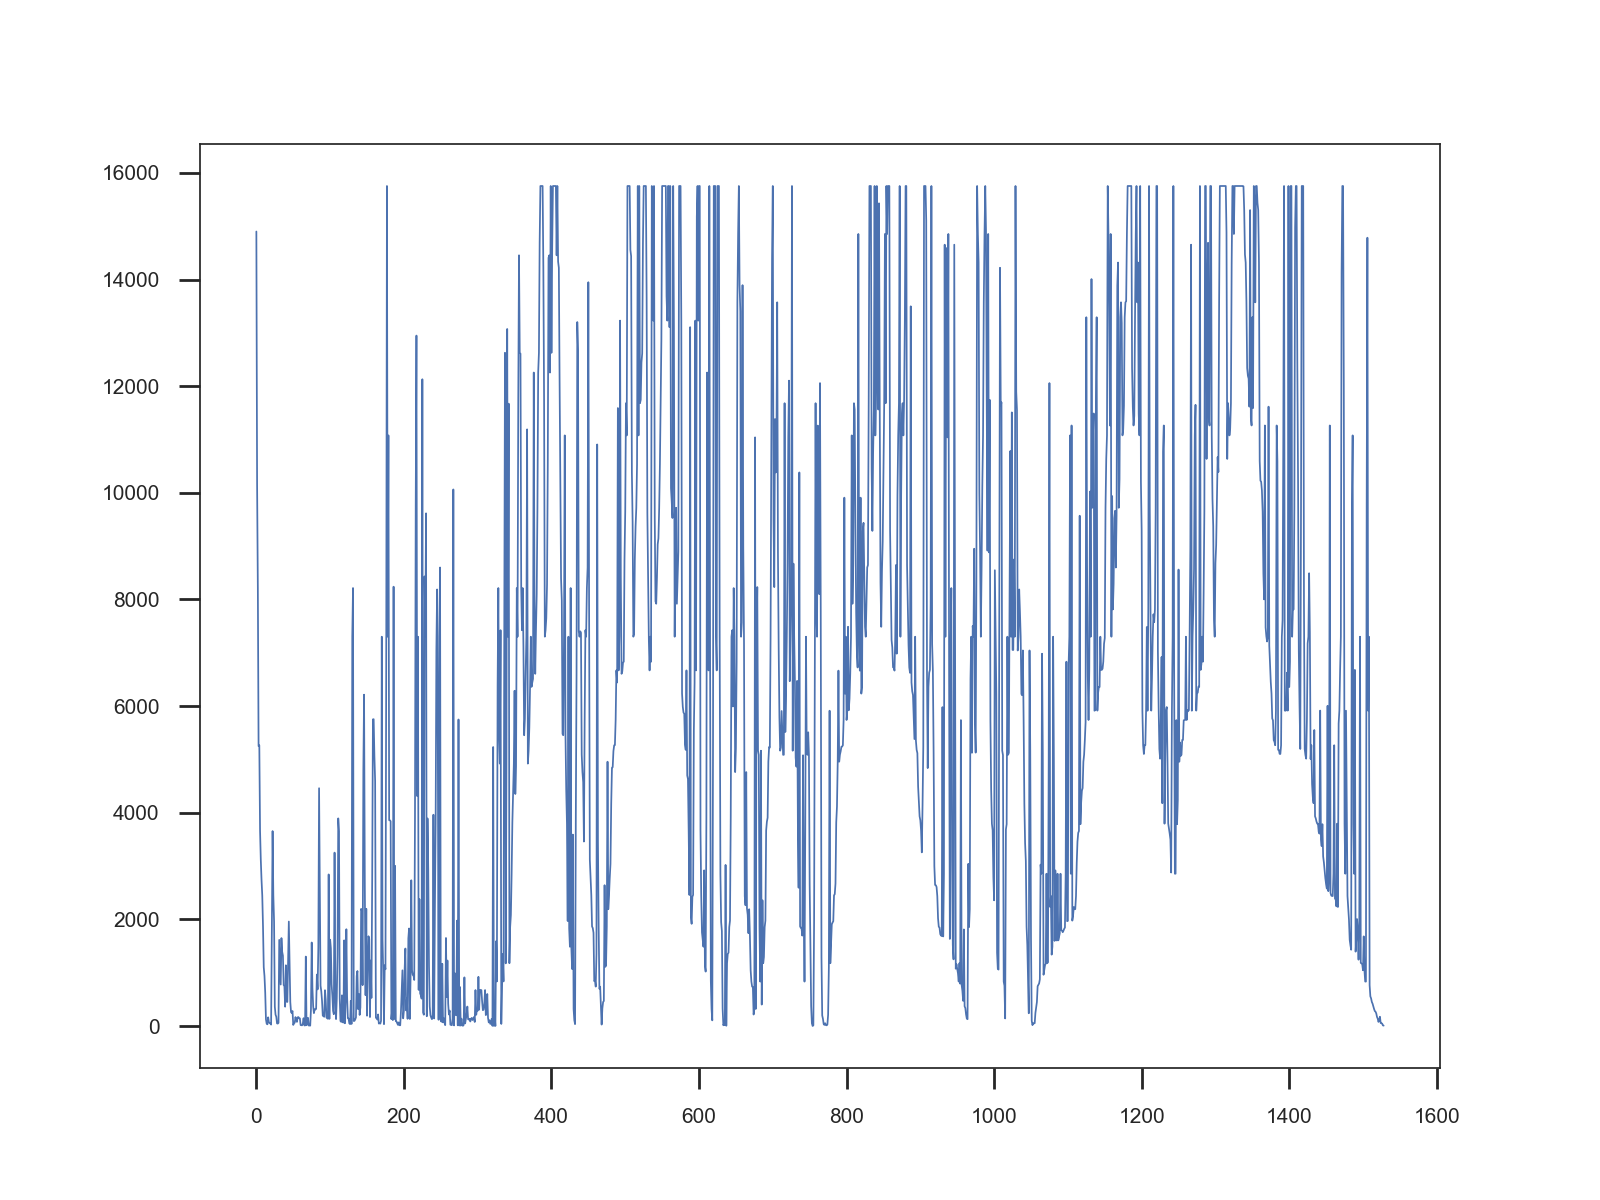

In [116]:
fig, ax = plt.subplots()
ax.plot(nspl_left);

In [121]:
nspd_left = pos_left[-1] - np.asarray(pos_left)[pos_left.shape[0] - nspl_left.clip(min=1)]
nspd_left

array([2165721, 1337349,  930635, ...,    4560,    1283,     403], dtype=int32)

<IPython.core.display.Javascript object>


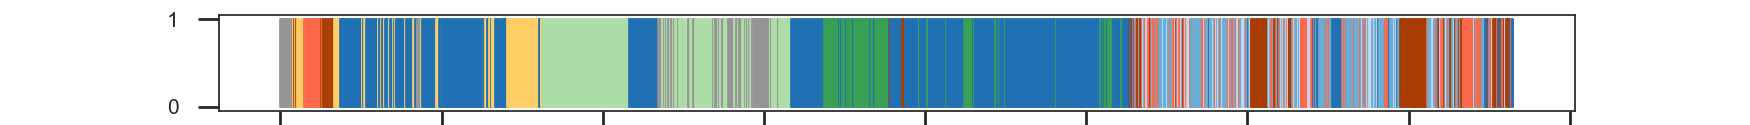

In [122]:
pops_left = df_haplotypes.population[idx_left]
pop_colors_left = [phase1_ar3.pop_colors[p] for p in pops_left]
fig, ax = plt.subplots(figsize=(7, .5))
ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors_left)

<IPython.core.display.Javascript object>


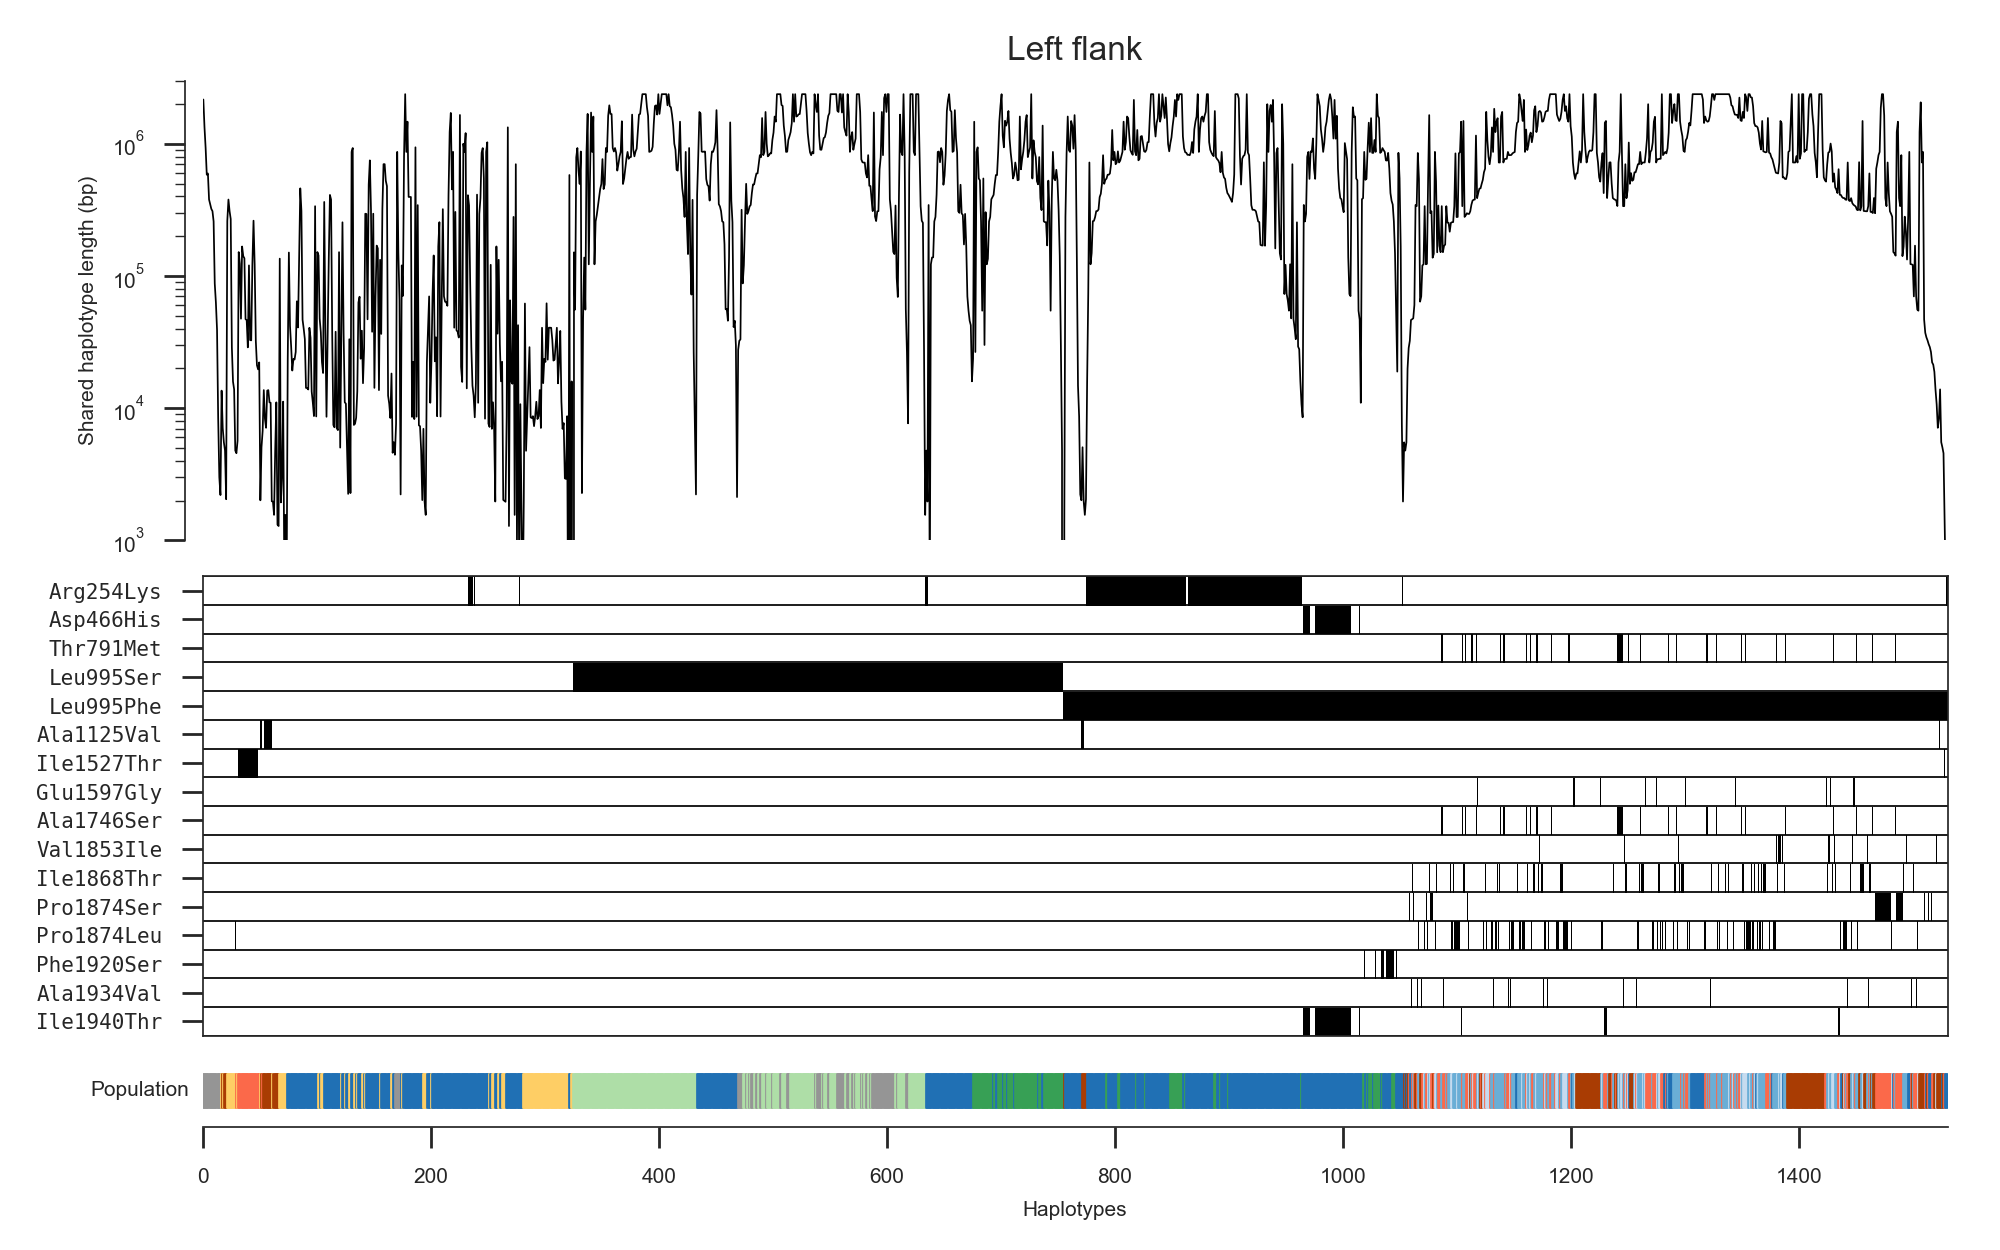

In [124]:
fig = plt.figure(figsize=(8, 5))
gs = mpl.gridspec.GridSpec(nrows=3, ncols=1, height_ratios=(6, 6, .5))

ax = fig.add_subplot(gs[0])
ax.set_title('Left flank')
sns.despine(ax=ax, offset=5, bottom=True)
# N.B., values are distances shared between haplotypes
x = np.arange(0, len(df_haplotypes))[:-1] + .5
y = nspd_left
ax.plot(x, y, color='k', lw=.5)
ax.set_yscale('log')
ax.set_ylim(1e3, 3e6)
ax.set_xlim(0, len(df_haplotypes))
ax.set_xticks([])
ax.set_ylabel('Shared haplotype length (bp)')

ax = fig.add_subplot(gs[1])
plot_haplotypes(ax, haps_vgsc_missense[:, idx_left], lbl_vgsc_missense)
ax.set_xlim(0, len(df_haplotypes))
ax.set_xticks([])

ax = fig.add_subplot(gs[2])
sns.despine(ax=ax, offset=5, left=True)
pops_right = df_haplotypes.population[idx_left]
pop_colors_right = [phase1_ar3.pop_colors[p] for p in pops_left]
ax.broken_barh([(i, 1) for i in range(len(df_haplotypes))], yrange=(0, 1), color=pop_colors_left)
ax.set_xlim(0, len(df_haplotypes))
ax.set_yticks([])
ax.set_ylabel('Population', rotation=0, ha='right', va='center')

ax.set_xlabel('Haplotypes')

fig.tight_layout(h_pad=0);

## Sandbox

In [6]:
pos_phased = allel.SortedIndex(callset_phased['2L/variants/POS'])
pos_phased

0,1,2,3,4,...,8296595,8296596,8296597,8296598,8296599
44688,44691,44732,44736,44756,...,49356424,49356425,49356426,49356429,49356435


In [8]:
loc_kdr_s = pos_phased.locate_key(2422651)
loc_kdr_s

26000

In [9]:
loc_kdr_f = pos_phased.locate_key(2422652)
loc_kdr_f

26001

In [51]:
flank_size = 80000

In [52]:
loc_right = slice(loc_kdr_s, loc_kdr_f+flank_size)
loc_left = slice(max(0, loc_kdr_s-flank_size+1), loc_kdr_f+1)
loc_right, loc_left

(slice(26000, 106001, None), slice(0, 26002, None))

In [53]:
h_right = allel.GenotypeArray(callset_phased['2L/calldata/genotype'][loc_right]).to_haplotypes()
h_left = allel.GenotypeArray(callset_phased['2L/calldata/genotype'][loc_left]).to_haplotypes()
pos_right = pos_phased[loc_right]
pos_left = pos_phased[loc_left]

In [54]:
idx_right = h_right.prefix_argsort()
h_right_sorted = h_right[:, idx_right]
h_right_sorted

<HaplotypeArray shape=(80001, 1546) dtype=int8>
0 0 0 0 0 ... 1 1 1 1 1
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
...
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0
0 0 0 0 0 ... 0 0 0 0 0

In [55]:
nspl_right = allel.opt.stats.neighbour_shared_prefix_lengths_int8(np.asarray(h_right_sorted))
nspl_right

array([ 185, 3867,  441, ...,   99,    5,  951], dtype=int32)

<IPython.core.display.Javascript object>


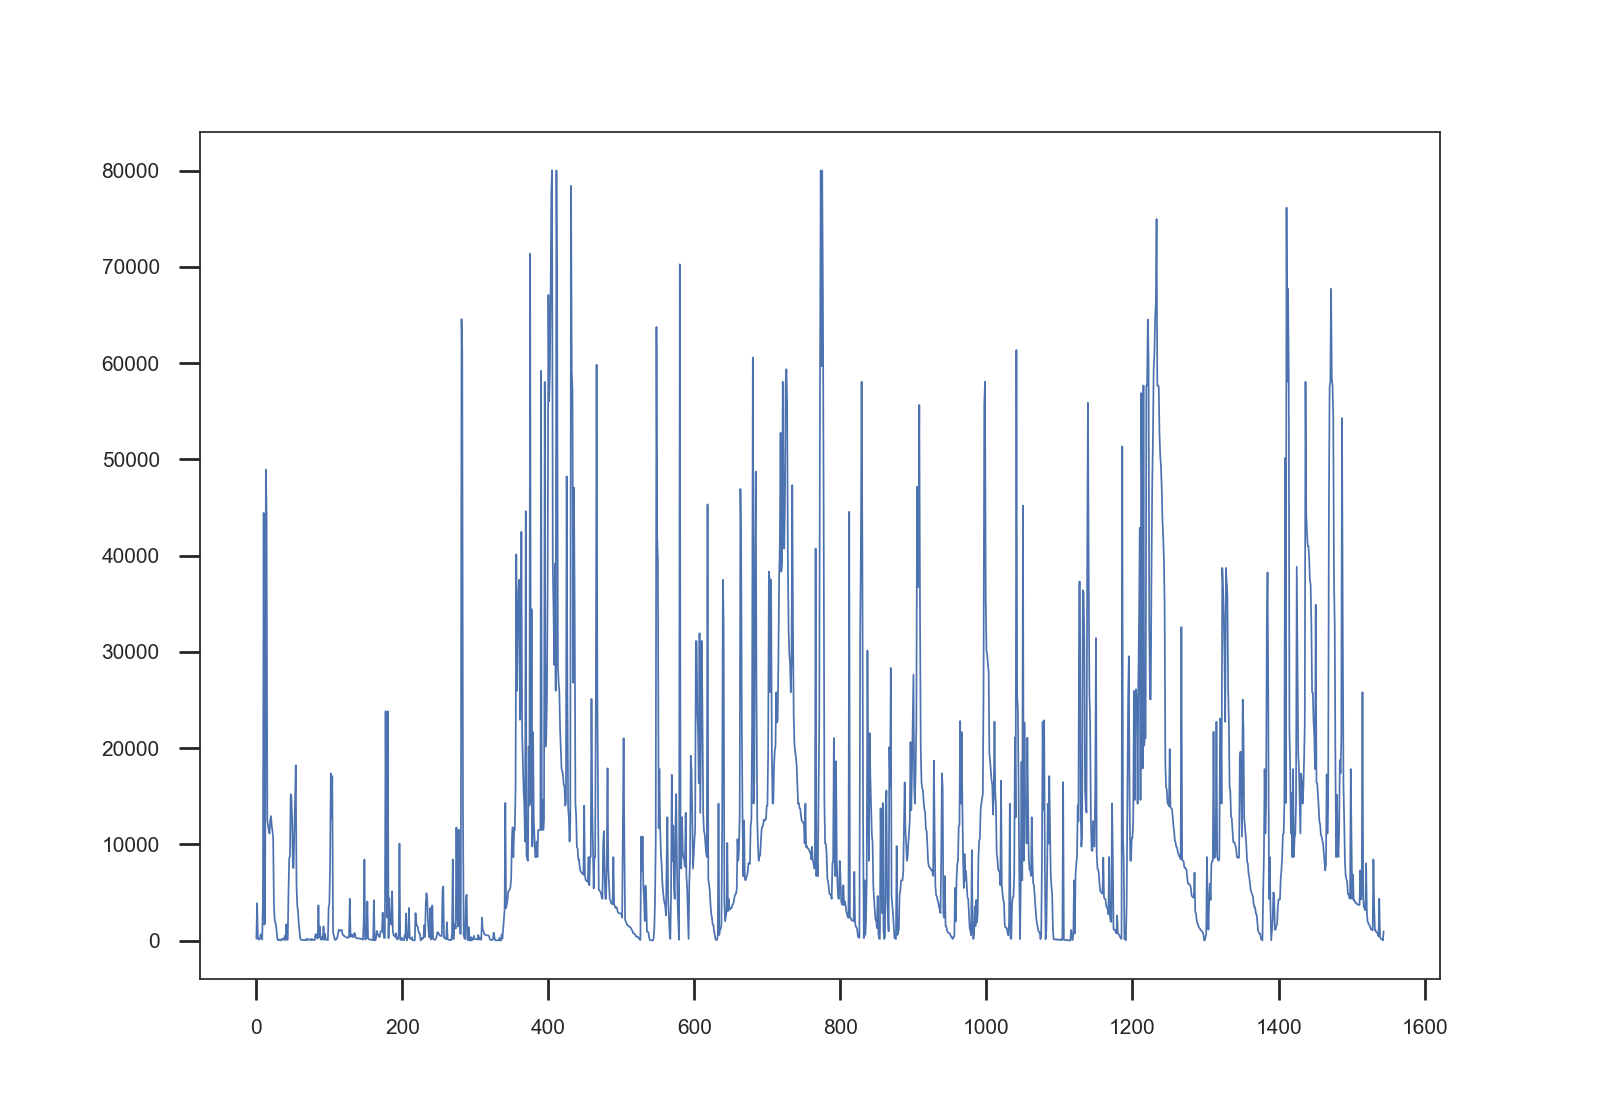

In [57]:
plt.plot(nspl_right);

In [56]:
nspl_right.min(), nspl_right.max()

(0, 80001)

In [60]:
nspl_right.clip(max=flank_size).max()

80000

In [64]:
nspd_right = np.asarray(pos_right)[nspl_right.clip(max=flank_size)] - pos_right[0]
nspd_right

array([  9151, 176765,  17560, ...,   4625,    259,  63712], dtype=int32)

<IPython.core.display.Javascript object>


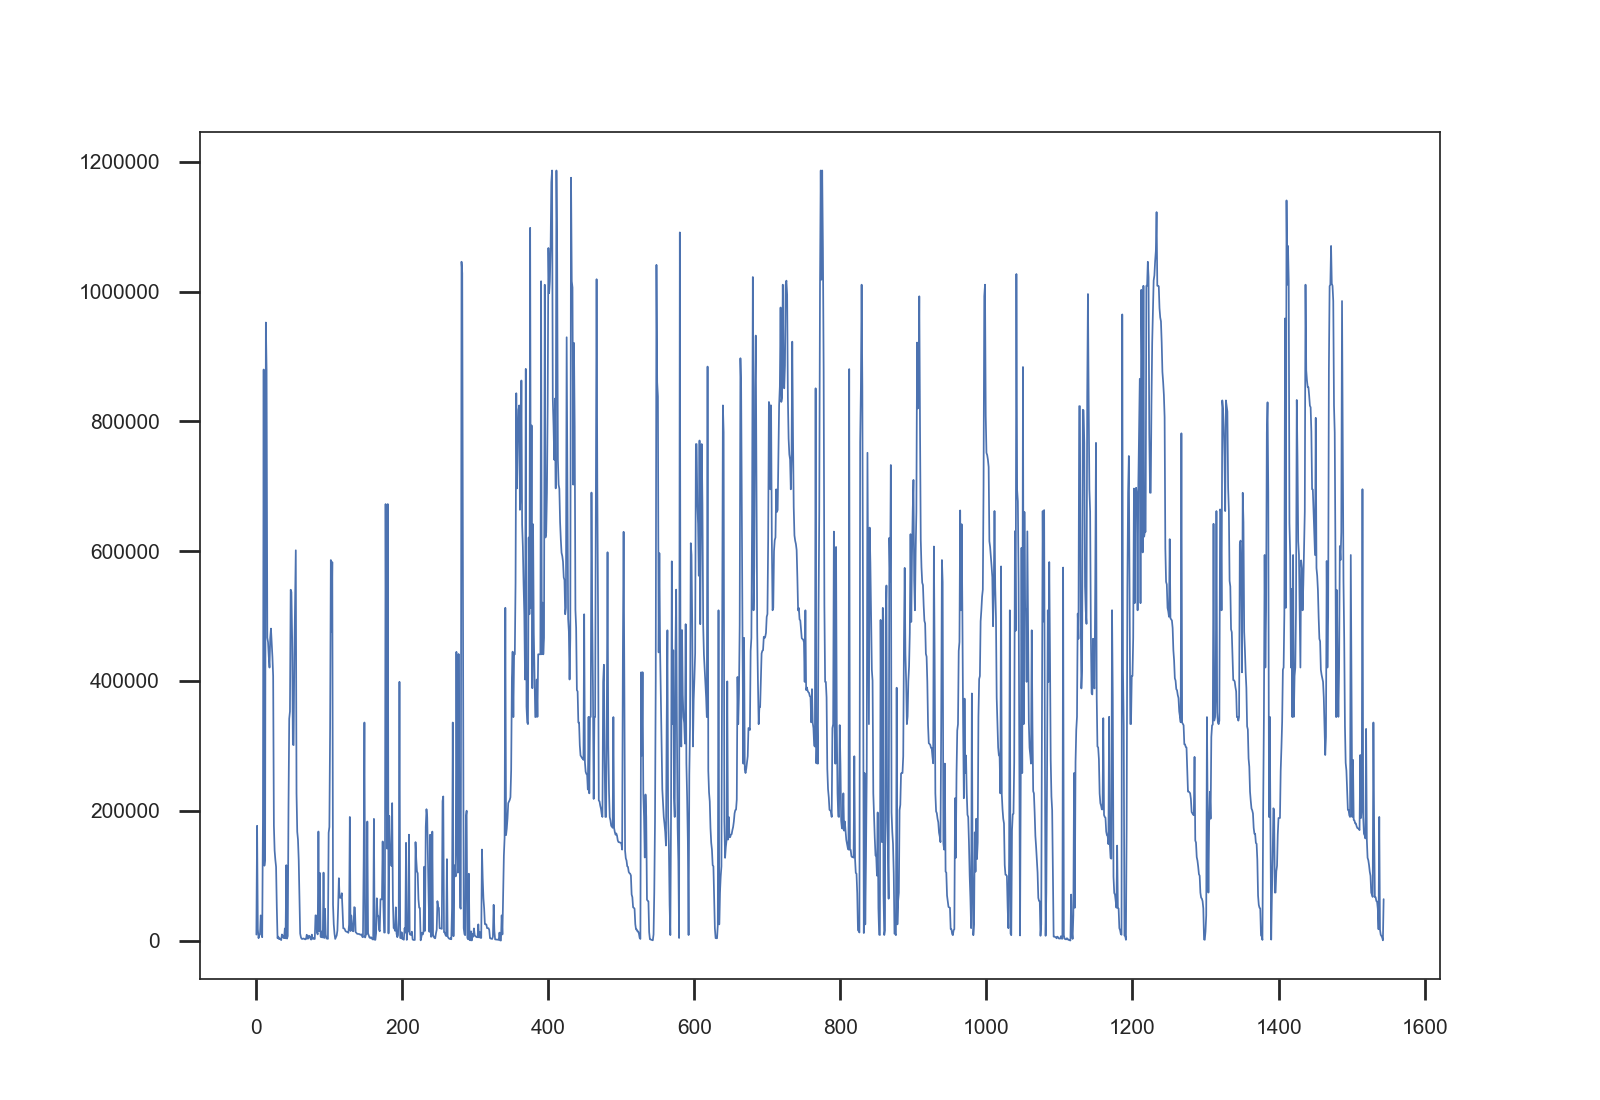

In [65]:
plt.plot(nspd_right);